In [1]:
# Imports
import pykep as pk
import pygmo as pg
import numpy as np
from pykep.orbit_plots import plot_planet, plot_lambert
from pykep import AU, DAY2SEC
import pygmo_plugins_nonfree as ppnf

# Plotting imports
%matplotlib notebook
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Testing random examples in pykep

### Example 1: Multiple impulses transfer between Earth and Venus

In [2]:
# We define the optimization problem
udp = pk.trajopt.pl2pl_N_impulses(
    start=pk.planet.jpl_lp('earth'),
    target=pk.planet.jpl_lp('venus'),
    N_max=3,
    tof=[100., 1000.],
    vinf=[0., 4],
    phase_free=False,
    multi_objective=False,
    t0=[pk.epoch(0), pk.epoch(1000)])
# All pykep problems in the module trajopt are compatible with pygmo.
# So we create a pygmo problem from the pykep udp (User Defined Problem)
prob = pg.problem(udp)
print(prob)

Problem name: <class 'pykep.trajopt._pl2pl_N_impulses.pl2pl_N_impulses'>
	C++ class name: pybind11::object

	Global dimension:			7
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 100, 0.001, 0, 0, ... ]
	Upper bounds: [1000, 1000, 0.999, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [3]:
# Here we define the solution strategy, which in this simple case is to use
# Covariance Matrix adaptation Evolutionary Strategy (CMA-ES)
uda = pg.cmaes(gen=1000, force_bounds = True)
algo = pg.algorithm(uda)
# Here we activate some degree of screen output (will only show in the terminal)
algo.set_verbosity(10)
# We construct a random population of 20 individuals (the initial guess)
pop = pg.population(prob, size = 20, seed = 123)
# We solve the problem
pop = algo.evolve(pop)

CMAES 4 PaGMO: 
mu: 10 - lambda: 20 - mueff: 5.9388 - N: 7
cc: 0.38186 - cs: 0.442549 - c1: 0.0267277 - cmu: 0.0944846 - sigma: 0.5 - damps: 1.44255 - chiN: 2.55383

   Gen:        Fevals:          Best:            dx:            df:         sigma:
      1              0        9706.34         857.52         818649            0.5
     11            200        19614.1        184.717        66407.6       0.237263
     21            400        10324.2        561.113        40165.5        0.10268
     31            600         6438.5        47.3957        46817.3      0.0794365
     41            800        6156.28         141.76          45190      0.0401805
     51           1000        6160.63        91.6942        34935.2      0.0420491
     61           1200        6105.17        11.4805        1677.99      0.0151286
     71           1400        6077.37        53.8339        65363.1       0.018673
     81           1600         6061.4        25.4988        3123.76      0.0217117
    

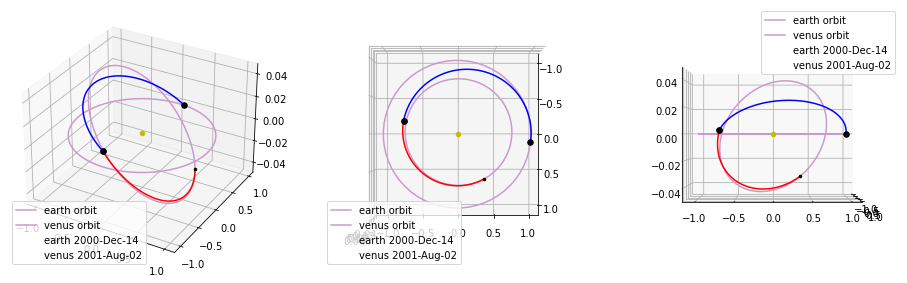

In [4]:
# Plot our trajectory
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax1 = udp.plot(pop.champion_x, axes = ax1)
ax2 = udp.plot(pop.champion_x, axes = ax2)
ax2.view_init(elev=90, azim=0)
ax3 = udp.plot(pop.champion_x, axes = ax3)
ax3.view_init(elev=0, azim=0)

In [5]:
# Inspect
udp.pretty(pop.champion_x)

Total DV (m/s):  5586.571466417641
Dvs (m/s):  [2426.2601735776957, 2648.1952838500833, 512.1160089898622]
Tofs (days):  [144.85597071586642, 85.8151695307143]


### Example 2: Multi revolutions Lambert Problem

In [6]:
# We define the Lambert problem
t1 = pk.epoch(0)
t2 = pk.epoch(640)
dt = (t2.mjd2000 - t1.mjd2000) * DAY2SEC

earth = pk.planet.jpl_lp('earth')
rE, vE = earth.eph(t1)

mars = pk.planet.jpl_lp('mars')
rM, vM = mars.eph(t2)

# We solve the Lambert problem
l = pk.lambert_problem(r1 = rE, r2 = rM, tof = dt, mu = pk.MU_SUN, max_revs=2)

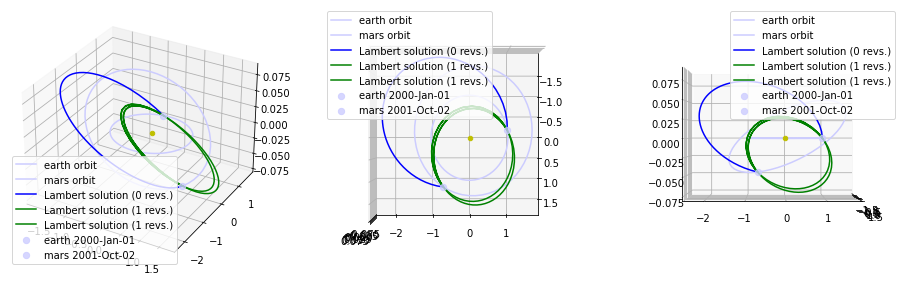

In [7]:
# We plot
mpl.rcParams['legend.fontsize'] = 10

# Create the figure and axis
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter([0], [0], [0], color=['y'])

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter([0], [0], [0], color=['y'])
ax2.view_init(90, 0)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter([0], [0], [0], color=['y'])
ax3.view_init(0,0)

for ax in [ax1, ax2, ax3]:
    # Plot the planet orbits
    plot_planet(earth, t0=t1, color=(0.8, 0.8, 1), legend=True, units=AU, axes=ax)
    plot_planet(mars, t0=t2, color=(0.8, 0.8, 1), legend=True, units=AU, axes=ax)
    # Plot the Lambert solutions
    axis = plot_lambert(l, color='b', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=1, color='g', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=2, color='g', legend=True, units=AU, axes=ax)

### Example 3: Mass optimal Mars Randezvous using a direct method


 objevals:        objval:      violated:    viol. norm:
         1       -132.815             22         5.1042 i
         2       -931.111             48        13.7759 i
         3        -505.97             23        2.14353 i
         4        -505.97             23        2.14353 i
         5       -822.218             48        9.29475 i
         6          -1000             35        4.05905 i
         7       -942.355             46        6.72091 i
         8       -925.828             44        7.90637 i
         9       -933.647             37        3.58608 i
        10       -933.647             37        3.58608 i
        11       -929.429             47        10.7962 i
        12       -932.768             34        2.72227 i
        13       -932.768             34        2.72227 i
        14       -887.188             47         9.2815 i
        15       -926.249             33        2.40977 i
        16       -926.249             33        2.40977 i
        17     

       277        -876.58         No solution found, try again :)

Low-thrust NEP transfer from earth to mars

Launch epoch: 1300.471732747767 MJD2000, a.k.a. 2003-Jul-24 11:19:17.709407
Arrival epoch: 2049.0984828086775 MJD2000, a.k.a. 2005-Aug-11 02:21:48.914670
Time of flight (days): 748.6267500609106 

Launch DV (km/s) 3.5000028996260624 - [2.2700606334896327,2.2145285271851294,1.4807796662416568]
Arrival DV (km/s) 1.0763764223985582e-06 - [3.664353262533175e-07,9.975516876599545e-07,-1.7088588243597072e-07]

Spacecraft Initial Position (m)  : [78551876715.61655, -130093180334.7451, 1081008.6346302629]
Spacecraft Initial Velocity (m/s): [27285.660187429174, 17500.6272326824, 1480.652646480529]
Spacecraft Initial Mass  (kg)    : 1000.0
Spacecraft Final Position (m)  : [205050717251.29178, -29964437388.833893, -5665148894.05915]
Spacecraft Final Velocity (m/s): [4433.008452054156, 26044.116394159195, 436.7172865917746]
Spacecraft Final Mass  (kg)    : 874.3523773396408


/opt/anaconda3/envs/pykep/lib/python3.9/site-packages/pykep/trajopt/_direct.py:73: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')


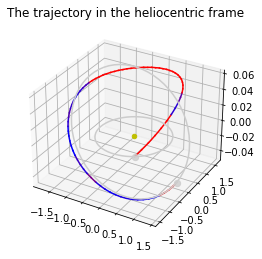

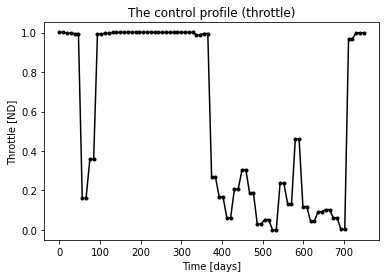

In [8]:
def run_example8(nseg=40):
    """
    This example demonstrates the direct method (sims-flanagan) on a planet to planet scenario.
    """
    import pykep as pk
    import pygmo as pg
    import numpy as np
    from matplotlib import pyplot as plt
    from pykep.examples import add_gradient, algo_factory

    # 1 - Algorithm
    algo = algo_factory("slsqp")

    # 2 - Problem
    udp = add_gradient(pk.trajopt.direct_pl2pl(
        p0="earth",
        pf="mars",
        mass=1000,
        thrust=0.1,
        isp=3000,
        vinf_arr=1e-6,
        vinf_dep=3.5,
        hf=False,
        nseg=nseg,
        t0=[1100, 1400],
        tof=[200, 750]),
        with_grad=True
    )

    prob = pg.problem(udp)
    prob.c_tol = [1e-5] * prob.get_nc()

    # 3 - Population
    pop = pg.population(prob, 1)

    # 4 - Solve the problem (evolve)
    pop = algo.evolve(pop)

    # 5 - Inspect the solution
    if prob.feasibility_x(pop.champion_x):
        print("Optimal Found!!")
    else:
        print("No solution found, try again :)")

    udp.udp_inner.pretty(pop.champion_x)

    axis = udp.udp_inner.plot_traj(pop.champion_x)
    plt.title("The trajectory in the heliocentric frame")
    axis = udp.udp_inner.plot_control(pop.champion_x)
    plt.title("The control profile (throttle)")

    plt.ion()
    plt.show()


if __name__ == "__main__":
    run_example8()

### Spice Kernels for Titan
Code Tutorial: https://esa.github.io/pykep/examples/hera_trajectory.html

To get this to work, you need to download the SPICE kernel yourself and drop it into the MissionToTitan directory. The Saturn file with Titan (sat427.bsp) is found from: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/satellites/. If you do not want to download the file yourself, run the cell below and it will download the file for you.

In [21]:
# Downloading the spice kernel
import os.path
    
if not os.path.exists("sat427.bsp") or not os.path.exists("de432s.bsp"):
    !pip install requests
    import requests
    
    url = "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/satellites/sat427.bsp"
    r = requests.get(url, allow_redirects=True)
    open('sat427.bsp', 'wb').write(r.content)
    
    print("Downloaded sat427.bsp!")
    
    url2 = "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de432s.bsp"
    r2 = requests.get(url2, allow_redirects=True)
    open('de432s.bsp', 'wb').write(r2.content)
    
    print("Downloaded de432s.bsp!")
    
else:
    print("File is already downloaded!")

File is already downloaded!


Position vector at epoch:  (1422585602850.5447, 42405151258.44917, -57864240725.83783)
Velocity vector at epoch:  (-5724.120066037978, 12241.917415220907, -991.904130304647)


<IPython.core.display.Javascript object>


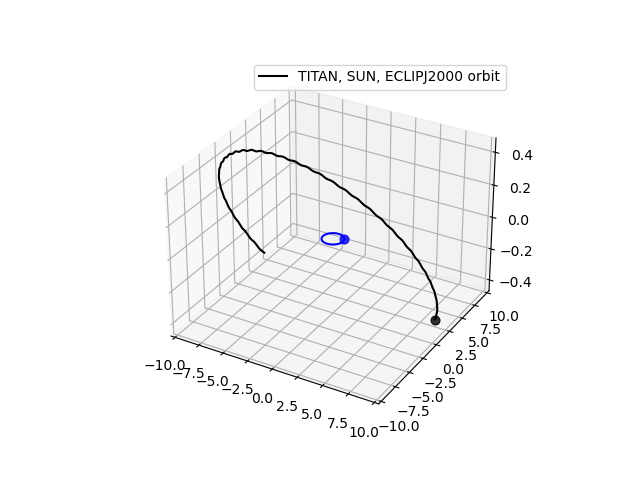

C:\Users\jdastoor3\Anaconda3\envs\pykep\lib\site-packages\pykep\orbit_plots\_plots.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


(-10.0, 10.0)

In [158]:
pk.util.load_spice_kernel("sat427.bsp")
pk.util.load_spice_kernel("de432s.bsp")

titan = pk.planet.spice('TITAN', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)
epoch = pk.epoch_from_string("2026-Jan-04 12:00:00")

r, v = titan.eph(epoch)
print("Position vector at epoch: ", r)
print("Velocity vector at epoch: ", v)

# Inputting the dates we care about
launch = pk.epoch_from_string("2026-OCT-25 12:00:00")
arrival = pk.epoch_from_string("2046-DEC-28 11:58:50.816")

# These are the solar system plants and orbiting objects we are intrerested in
earth = pk.planet.spice('EARTH', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, pk.MU_EARTH, pk.EARTH_RADIUS, pk.EARTH_RADIUS*1.05)

# And these are the plotting commands
ax = pk.orbit_plots.plot_planet(titan, t0 = launch, tf = arrival, N=500, units=pk.AU, legend=(False,True))
pk.orbit_plots.plot_planet(earth, t0 = launch, axes=ax, color = 'b', units=pk.AU)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

<IPython.core.display.Javascript object>


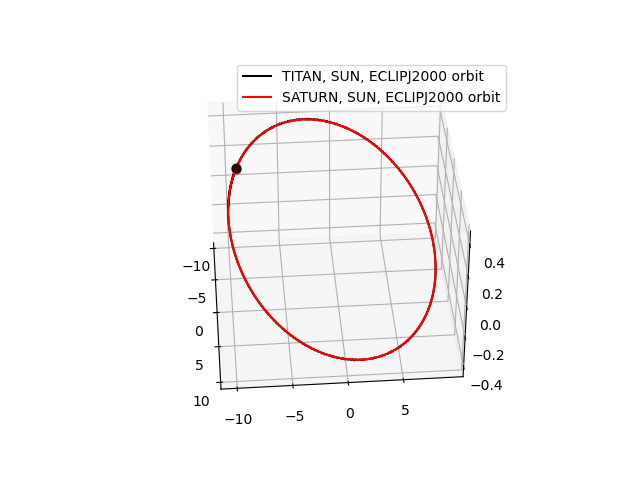

C:\Users\jdastoor3\Anaconda3\envs\pykep\lib\site-packages\pykep\orbit_plots\_plots.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


<Axes3DSubplot:>

In [23]:
# We can also plot Titan relative to Saturn using the SPICE kernel or using jpl_lp
# The SPICE kernel does not seem to be working, so we're just going to use jpl_lp

launch = pk.epoch_from_string("2015-OCT-25 12:00:00")
arrival = pk.epoch_from_string("2046-DEC-28 11:58:50.816")

titan = pk.planet.spice('TITAN', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)
saturn = pk.planet.spice('SATURN', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)

ax = pk.orbit_plots.plot_planet(titan, t0 = launch, tf = arrival, N=500, units=pk.AU, legend=(False,True))
pk.orbit_plots.plot_planet(saturn, t0 = launch, axes = ax, color="r", units=pk.AU, legend=(False,True))

### Multiple-Gravity Assist Trajectory Optimization

Some observations from the Juice and TandEM examples:
1. All of ESA's examples for similar missions tend to use the MGA_1DSM class which is a multiple gravity assist with one deep space maneuver per leg optimization problem.
2. You have to select an objective, whether that be time, or payload mass, etc. However, you can set this up to be a multi-objective problem, where you are optimizing for multiple things. We would likely be optimizing for $\Delta V$ and time.
3. ESA always incorporates a launcher model to use with the optimization (this is mainly to optimize for mass though).
4. There is always a "fitness" function, which is the main function, and a "pretty" function which prints human readable information (the pretty function is always the exact same).

*** Notes: SPICE kernels used are only valid to 2050. Have to play with t0 and tof to make sure the total duration goes to less than 2050. 

In [159]:
from pykep.trajopt import mga_1dsm, launchers
from pykep.planet import jpl_lp
from pykep import epoch_from_string

import numpy as np
from numpy.linalg import norm
from math import log, acos, cos, sin, asin, exp
from copy import deepcopy

class _tandem_udp(mga_1dsm):
    """ 
    This class represents a rendezvous mission to Saturn modelled as an MGA-1DSM transfer. Mission parameters are
    inspired to the TandEM mission. A launcher model (i.e. Atlas 501) is also used, so that the final mass delivered
    at Saturn is the main objective of this optimization problem.

    The problem draws inspiration from the work performed in April 2008 by the
    European Space Agency working group on mission analysis on the mission named TandEM. TandEM is an interplanetary
    mission aimed at reaching Titan and Enceladus (two moons of Saturn). 

    .. note::

       The Titan and Enceladus Mission (TandEM), an ambitious scientific mission to study the Saturnian system
       with particular emphasis on the moons Titan and Enceladus, was selected in October 2007 as a candidate mission
       within the ESA Cosmic Vision plan. In February 2009, TandEM exited the Cosmic Vision programme when ESA
       and NASA chose EJSM-Laplace as the L-class outer Solar System mission candidate.

    .. note::

       A significantly similar version of this problem was part of the no longer maintained GTOP database, 
       https://www.esa.int/gsp/ACT/projects/gtop/gtop.html. The exact definition is, though, different and results
       cannot thus not be compared to those posted in GTOP.
    """
    def __init__(self, prob_id = 1, constrained = True):
        """ 
        The TandEM problem of the trajectory gym consists in 48 different instances varying in fly-by sequence and
        the presence of a time constraint.

        Args:
            - prob_id (``int``): The problem id defines the fly-by sequence.
            - constrained (``bool``): Activates the constraint on the time of flight 
              (fitness will thus return two numbers, the objective function and the inequality constraint violation)
        """
        # Redefining the planets as to change their safe radius
        earth = pk.planet.spice('EARTH BARYCENTER', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, pk.MU_EARTH, pk.EARTH_RADIUS, pk.EARTH_RADIUS*1.05)
        
        venus = pk.planet.spice('VENUS BARYCENTER', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)
        venus.safe_radius = 1.05
        
        mars = pk.planet.spice('MARS BARYCENTER', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)
        mars.safe_radius = 1.05
        
        jupiter = pk.planet.spice('JUPITER BARYCENTER', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)
        jupiter.safe_radius = 1.7
        
        saturn = pk.planet.spice('SATURN BARYCENTER', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)
        saturn.safe_radius = 1.5
        
        titan = pk.planet.spice('TITAN', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100)

        # Defining the different sequences
        seq_tandem = []
        seq_tandem.append([earth, venus, venus, venus, saturn, titan])
        seq_tandem.append([earth, venus, venus, earth, saturn, titan])
        seq_tandem.append([earth, venus, venus, mars, saturn, titan])
        seq_tandem.append([earth, venus, venus, jupiter, saturn, titan])

        seq_tandem.append([earth, venus, earth, venus, saturn, titan])
        seq_tandem.append([earth, venus, earth, earth, saturn, titan])
        seq_tandem.append([earth, venus, earth, mars, saturn, titan])
        seq_tandem.append([earth, venus, earth, jupiter, saturn, titan])

        seq_tandem.append([earth, venus, mars, venus, saturn, titan])
        seq_tandem.append([earth, venus, mars, earth, saturn, titan])
        seq_tandem.append([earth, venus, mars, mars, saturn, titan])
        seq_tandem.append([earth, venus, mars, jupiter, saturn, titan])

        seq_tandem.append([earth, earth, venus, venus, saturn, titan])
        seq_tandem.append([earth, earth, venus, earth, saturn, titan])
        seq_tandem.append([earth, earth, venus, mars, saturn, titan])
        seq_tandem.append([earth, earth, venus, jupiter, saturn, titan])

        seq_tandem.append([earth, earth, earth, venus, saturn, titan])
        seq_tandem.append([earth, earth, earth, earth, saturn, titan])
        seq_tandem.append([earth, earth, earth, mars, saturn, titan])
        seq_tandem.append([earth, earth, earth, jupiter, saturn, titan])

        seq_tandem.append([earth, earth, mars, venus, saturn, titan])
        seq_tandem.append([earth, earth, mars, earth, saturn, titan])
        seq_tandem.append([earth, earth, mars, mars, saturn, titan])
        seq_tandem.append([earth, earth, mars, jupiter, saturn, titan])

        if prob_id > 24 or type(prob_id) != int or prob_id < 1:
            raise ValueError("TandEM problem id must be an integer in [1, 24]")

        super().__init__(
            seq = seq_tandem[prob_id - 1],
            t0 = [pk.epoch_from_string("2021-DEC-28 11:58:50.816"), pk.epoch_from_string("2027-DEC-28 11:58:50.816")],
            tof = [[20, 1000], [20, 1000], [20, 1000], [20, 1000], [20,1000]],
            vinf = [2.5, 4.9],
            add_vinf_dep = False,
            add_vinf_arr = True,
            tof_encoding = 'direct',
            multi_objective = False,
            orbit_insertion = True,
            e_target = 0.98531407996358,
            rp_target = 80330000,
            eta_lb = 0.01,
            eta_ub = 0.99,
            rp_ub = 10
        )

        self.prob_id = prob_id
        self.constrained = constrained

    def fitness(self, x):
        T, Vinfx, Vinfy, Vinfz = self._decode_times_and_vinf(x)
        # We transform it (only the needed component) to an equatorial system rotating along x 
        # (this is an approximation, assuming vernal equinox is roughly x and the ecliptic plane is roughly xy)
        earth_axis_inclination = 0.409072975
        # This is different from the GTOP tanmEM problem, I think it was bugged there as the rotation was in the wrong direction.
        Vinfz = - Vinfy * sin(earth_axis_inclination) + Vinfz * cos(earth_axis_inclination)
        # And we find the vinf declination (in degrees)
        sindelta = Vinfz / x[3]
        declination = asin(sindelta) / np.pi * 180.
        # We now have the initial mass of the spacecraft
        m_initial = launchers.atlas501(x[3] / 1000., declination)
        # And we can evaluate the final mass via Tsiolkowsky
        Isp = 312.
        g0 = 9.80665
        DV = super().fitness(x)[0]
        DV = DV + 165.  # losses for 3 swgbys + insertion
        m_final = m_initial * exp(-DV / Isp / g0)
        # Numerical guard for the exponential
        if m_final == 0:
            m_final = 1e-320
        if self.constrained:
            retval = [-log(m_final), sum(T) - 3652.5]
        else:
            retval = [-log(m_final), ]
        return retval

    def get_nic(self):
        return int(self.constrained)

    def get_name(self):
        return "TandEM problem, id: " + str(self.prob_id)

    def get_extra_info(self):
        retval = "\t Sequence: " + \
            [pl.name for pl in self._seq].__repr__() + "\n\t Constrained: " + \
            str(self.constrained)
        return retval
    
    def pretty(self, x):
        """
        prob.plot(x)

        - x: encoded trajectory

        Prints human readable information on the trajectory represented by the decision vector x

        Example::

          print(prob.pretty(x))
        """
        super().pretty(x)
        T, Vinfx, Vinfy, Vinfz = self._decode_times_and_vinf(x)
        # We transform it (only the needed component) to an equatorial system rotating along x 
        # (this is an approximation, assuming vernal equinox is roughly x and the ecliptic plane is roughly xy)
        earth_axis_inclination = 0.409072975
        # This is different from the GTOP tanmEM problem, I think it was bugged there as the rotation was in the wrong direction.
        Vinfz = - Vinfy * sin(earth_axis_inclination) + Vinfz * cos(earth_axis_inclination)
        # And we find the vinf declination (in degrees)
        sindelta = Vinfz / x[3]
        declination = asin(sindelta) / np.pi * 180.
        m_initial = launchers.soyuzf(x[3] / 1000., declination)
        # And we can evaluate the final mass via Tsiolkowsky
        Isp = 312.
        g0 = 9.80665
        DV = super().fitness(x)[0]
        DV = DV + 165.  # losses for 3 swgbys + insertion
        m_final = m_initial * exp(-DV / Isp / g0)
        print("\nInitial mass:", m_initial)
        print("Final mass:", m_final)
        print("Declination:", declination)

    def __repr__(self):
        return "TandEM (Trajectory Optimisation Gym P12, multiple instances)"

# Problem P12: TandEM mission MGA1DSM, single objective, direct encoding, time constrained
tandem = _tandem_udp

Running a Self-Adaptive Differential Evolution Algorithm .... on 8 parallel islands
Done!! Solutions found are:  [array([  44.4873298 , -586.05069649]), array([100.28361635, -37.12462344]), array([  55.16067048, -875.26117822]), array([  108.78275532, -1180.67000899]), array([  79.05614417, -223.59537818]), array([ 144.44080769, -987.90458527]), array([  47.62725338, -315.03760093]), array([  88.92357829, -773.36083364])]
First Leg: EARTH BARYCENTER, SUN, ECLIPJ2000 to VENUS BARYCENTER, SUN, ECLIPJ2000
Departure: 2026-Mar-13 06:33:17.624297 (9568.27312065159 mjd2000) 
Duration: 173.57905928944055days
VINF: 2.752579427166742 km/sec
DSM after 2.7215407853121585 days
DSM magnitude: 12369.038212165202m/s

leg no. 2: VENUS BARYCENTER, SUN, ECLIPJ2000 to MARS BARYCENTER, SUN, ECLIPJ2000
Duration: 607.2774017714955days
Fly-by epoch: 2026-Sep-02 20:27:08.346905 (9741.85217994103 mjd2000) 
Fly-by radius: 6.369761385930134 planetary radii
DSM after 384.8164139381475 days
DSM magnitude: 20104.393

<IPython.core.display.Javascript object>


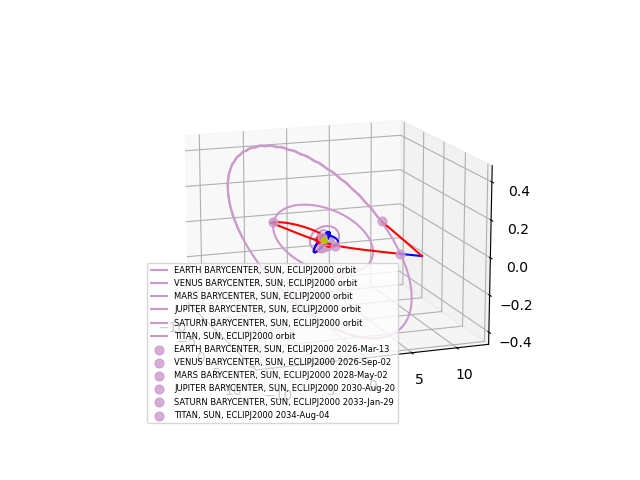

C:\Users\jdastoor3\Anaconda3\envs\pykep\lib\site-packages\pykep\trajopt\_mga_1dsm.py:384: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = fig.gca(projection='3d')


In [156]:
# We define an Earth-Venus-Earth problem (single-objective)
def run_tandem():
    #seq = [jpl_lp('earth'), jpl_lp('venus'), jpl_lp('earth')]
    udp = _tandem_udp(prob_id = 12)
    
    prob = pg.problem(udp)
    # We solve it!!
    uda = pg.sade(gen=100)
    islands = 8
    archi = pg.archipelago(algo=uda, prob=udp, n=islands, pop_size=20)
    print(
        "Running a Self-Adaptive Differential Evolution Algorithm .... on {} parallel islands".format(islands))
    archi.evolve(10)
    archi.wait()
    sols = archi.get_champions_f()
    sols2 = [item[0] for item in sols]
    idx = sols2.index(min(sols2))
    print("Done!! Solutions found are: ", archi.get_champions_f())
    udp.pretty(archi.get_champions_x()[idx])
    axis = udp.plot(archi.get_champions_x()[idx])
    axis.legend(fontsize=6)

if __name__ == "__main__":
    run_tandem()